In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os, gc
# os.listdir()


In [2]:
train_df = pd.read_csv('store_data/train_df_save4.csv')
test_df  = pd.read_csv('store_data/test_df_save4.csv')
sub      = pd.read_csv('sample_submission_24jSKY6.csv')
info_df  = pd.read_excel('train_aox2Jxw/Data Dictionary.xlsx')

train_df.shape, test_df.shape

((224607, 216), (112392, 215))

In [3]:
intersting_cols = ['manufacturer_id','Employment.Type','State_ID','Aadhar_flag','PAN_flag','VoterID_flag',
'Driving_flag','Passport_flag','SEC.NO.OF.ACCTS','SEC.ACTIVE.ACCTS','SEC.OVERDUE.ACCTS',
'SEC.INSTAL.AMT','NEW.ACCTS.IN.LAST.SIX.MONTHS','DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
'month_of_birth','credit_hist_year','credit_hist_month','loan_tenure_year','loan_tenure_month',
'day_of_disbursal','month_of_disbursal','Bureau_desc','no_of_loans','no_of_acc','no_of_acc_overdue',
'diff_of_acc','negative_income','income_status','credit_history','loan_tenure','ltv_round_cat',
'no_of_inquiry','state1_max','state1_count','manufac1_max','manufac2_count']

In [4]:
train_df[intersting_cols].shape, test_df[intersting_cols].shape

((224607, 36), (112392, 36))

In [42]:
sub

,UniqueID,loan_default
0,655269,0
1,723482,0
2,758529,0
3,763449,0
4,708663,0
5,725530,0
6,708592,0
7,714975,0
8,712795,0
9,708656,0


In [44]:
def run_cat_small(file_path, train_df, target, test_df, sub, depth):
    
    splits = 4
    from sklearn.model_selection import KFold, StratifiedKFold
    from sklearn.metrics import roc_auc_score
    from catboost import Pool, CatBoostClassifier

    features = train_df.columns
    random_seed = 2019
    
    model = CatBoostClassifier(loss_function         = "Logloss", 
                               eval_metric           = "AUC",
                               random_strength       = 1.5,
                               border_count          = 128,
                               scale_pos_weight      = 3.507,
                               depth                 = depth, 
                               early_stopping_rounds = 50,
                               random_seed           = 1337,
                               task_type             = 'CPU', 
    #                            subsample           = 0.7, 
                               iterations            = 10000, 
                               learning_rate         = 0.09,
                               thread_count          = 4
                              )


    n_split = splits
    kf = StratifiedKFold(n_splits=n_split, shuffle=True, random_state=random_seed)

    y_valid_pred = 0 * target
    oof_cat = np.zeros(len(train_df))
    y_test_pred = 0


    for idx, (train_index, valid_index) in enumerate(kf.split(train_df, target)):
        y_train, y_valid = target.iloc[train_index], target.iloc[valid_index]
        X_train, X_valid = train_df.iloc[train_index,:], train_df.iloc[valid_index,:]
        _train = Pool(X_train, label=y_train)#, cat_features=cate_features_index)
        _valid = Pool(X_valid, label=y_valid)#, cat_features=cate_features_index)
#         print( "\nFold ", idx)

        fit_model = model.fit(_train, 
                              eval_set=_valid,
                              use_best_model=True,
                              verbose=100
                             )
        pred = fit_model.predict_proba(X_valid)[:,1]
        score = roc_auc_score(y_valid, pred)
        print( "  auc = ", score )
        print("="*60)
        break
        y_test_pred = fit_model.predict_proba(test_df)[:,1]


    sub_df = pd.DataFrame({"ID_code":sub.UniqueID})
    sub_df["target"] = y_test_pred
    sub_df.columns = sub.columns


    sub_df.to_csv('submission/catboost_{}.csv'.format(file_path), index=None)

    cat_imp = pd.DataFrame(data=[fit_model.feature_names_, 
                                 list(fit_model.feature_importances_)]).T
    cat_imp.columns = ['feature','imp']
    cat_imp = cat_imp.sort_values(by='imp', ascending=False).head(50)
    plt.figure(figsize=(12,15))
    plt.barh(cat_imp.feature, cat_imp.imp)
    plt.show()
    
    return score

In [6]:
most_imp = ['ltv', 'disbursed_amount', 'year_of_birth','no_of_acc_overdue','month_of_disbursal',
 'Employee_code_ID','Current_pincode_ID','State_ID', 'day_of_disbursal','day_of_birth',
 'NEW.ACCTS.IN.LAST.SIX.MONTHS','no_of_inquiry','PRI.SANCTIONED.AMOUNT','credit_hist_year',
 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS','emp_code1_sum','branch1_max','PRIMARY.INSTAL.AMT',
 'manufacturer_id','manufac1_max']
target = train_df.loan_default
train_df = train_df[list(set(intersting_cols + most_imp))]
test_df  = test_df[list(set(intersting_cols + most_imp))]
train_df.shape, test_df.shape, target.shape

((224607, 46), (112392, 46), (224607,))

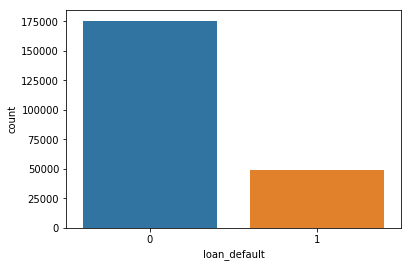

In [7]:
sns.countplot(target)

0:	test: 0.6004245	best: 0.6004245 (0)	total: 138ms	remaining: 23m 2s
100:	test: 0.6570856	best: 0.6570856 (100)	total: 5.77s	remaining: 9m 25s
200:	test: 0.6642501	best: 0.6642501 (200)	total: 11.5s	remaining: 9m 20s
300:	test: 0.6668094	best: 0.6668094 (300)	total: 17.1s	remaining: 9m 10s
400:	test: 0.6683111	best: 0.6683146 (399)	total: 22.7s	remaining: 9m 4s
500:	test: 0.6699182	best: 0.6699283 (498)	total: 30s	remaining: 9m 29s
600:	test: 0.6705393	best: 0.6705398 (564)	total: 37s	remaining: 9m 38s
700:	test: 0.6709465	best: 0.6709465 (700)	total: 43.6s	remaining: 9m 37s
800:	test: 0.6712730	best: 0.6712730 (800)	total: 49.9s	remaining: 9m 33s
900:	test: 0.6714016	best: 0.6714421 (889)	total: 56.1s	remaining: 9m 26s
1000:	test: 0.6715565	best: 0.6716025 (978)	total: 1m 2s	remaining: 9m 22s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6716831331
bestIteration = 1027

Shrink model to first 1028 iterations.
  auc =  0.6716831331441636


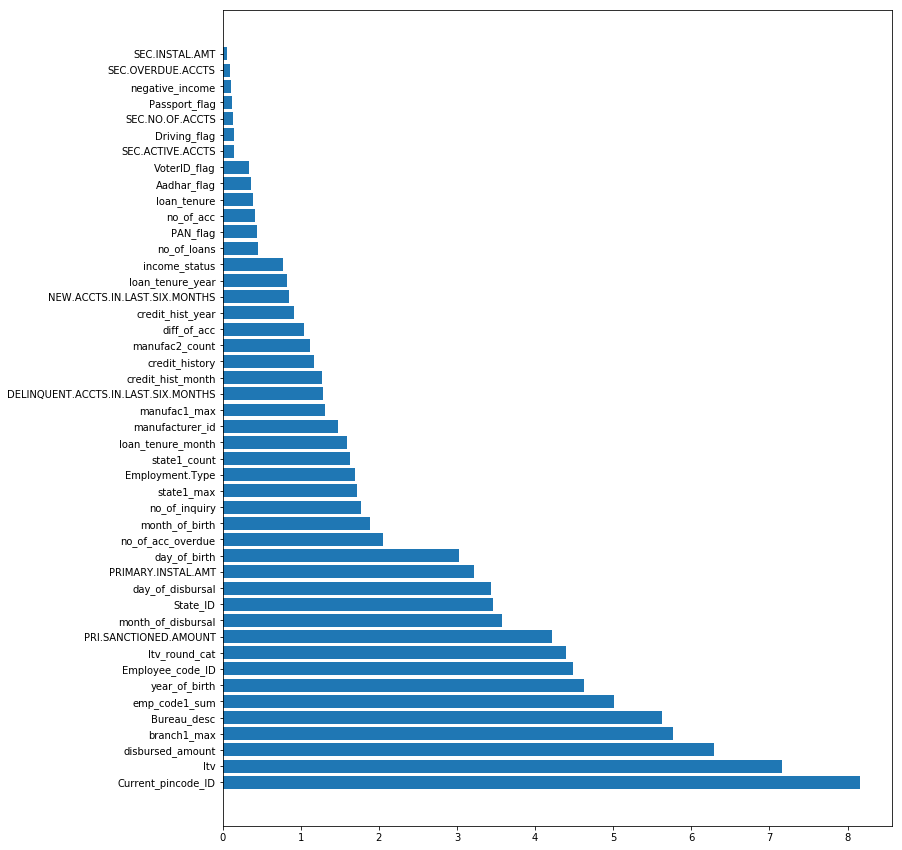

0.6716831331441636

In [26]:
run_cat_small(train_df, target, 5)

In [7]:
# run_cat_small(pd.get_dummies(train_df, columns=intersting_cols, drop_first=True), 
#               target, 5)

In [7]:
train_df_save = train_df.copy()
test_df_save  = test_df.copy()

In [8]:
count = 0
print("len of interst cols: ", len(intersting_cols))
for i in range(len(intersting_cols)-1):
#     print(i,"==>", end=" ")
    for j in range(i+1,len(intersting_cols)):
#         print(j, end=" ")
#     print(" ")
        count += 1
    
print("total combinations: ", count)

len of interst cols:  36
total combinations:  630


In [9]:
train_df.isnull().sum()

Employment.Type                          0
SEC.ACTIVE.ACCTS                         0
loan_tenure                              0
Driving_flag                             0
negative_income                          0
Passport_flag                            0
Current_pincode_ID                       0
SEC.NO.OF.ACCTS                          0
credit_hist_year                         0
Employee_code_ID                         0
credit_history                           0
ltv                                      0
no_of_acc                                0
State_ID                                 0
no_of_loans                              0
ltv_round_cat                            0
month_of_birth                           0
no_of_acc_overdue                        0
NEW.ACCTS.IN.LAST.SIX.MONTHS             0
disbursed_amount                         0
state1_max                               0
no_of_inquiry                            0
income_status                            0
DELINQUENT.

In [10]:
train_df.fillna(0, inplace=True)
test_df.fillna(0, inplace=True)


In [11]:
train_df.isnull().sum()

Employment.Type                        0
SEC.ACTIVE.ACCTS                       0
loan_tenure                            0
Driving_flag                           0
negative_income                        0
Passport_flag                          0
Current_pincode_ID                     0
SEC.NO.OF.ACCTS                        0
credit_hist_year                       0
Employee_code_ID                       0
credit_history                         0
ltv                                    0
no_of_acc                              0
State_ID                               0
no_of_loans                            0
ltv_round_cat                          0
month_of_birth                         0
no_of_acc_overdue                      0
NEW.ACCTS.IN.LAST.SIX.MONTHS           0
disbursed_amount                       0
state1_max                             0
no_of_inquiry                          0
income_status                          0
DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS    0
SEC.INSTAL.AMT  

In [12]:
# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()

# for col in intersting_cols:
#     try:
#         le.fit(list(train_df[col]) + list(test_df[col]))
#         print(le.classes_)
#         train_df[col] = le.transform(train_df[col])
#         test_df[col] = le.transform(test_df[col])
#     except:
#         print(col)

    

[ 45  48  49  51  67  86 120 145 152 153 155 156]
[0 1]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 19 23 27 29 33 57]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 20]
[0 1 2 3 4 7 8]
[0 1]
[0 1 2]
[0 1 2]
[ 1  2  3  4  5  6  7  8  9 10 11 12]
[0 1 2 3 4 5]
[ 0  1  2  3  4  5  6  7  8  9 10 11]
[0 1 2 3 4 5]
[ 0  1  2  3  4  5  6  7  8  9 10 11]
[ 8  9 10 11 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31]
[ 1  2  3  4  5  6  7  8  9 10 11 12]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
[0 1 2]
[0 1 2 3]
[0 1 2]
[0 1 2 3 4]
[0 1]
[0 1 2 3 4 5]
[0 1 2 3 4 5 6]
[0 1 2 3 4]
[ 0  1  2  3  4  5  6  7  8  9 10 11]
[0 1 2 3]
[102165 105571 109217 112052 115591 125044 125376 126382 127064 127165
 127330 128344 128875 128882 128950 129526 129549 129945 129995 130354
 130373 130377 130586 131017 131132 131534 131609 131610 131622 131738
 131769 131861 132000 132389 132417 132497 13252

In [25]:
# train_df[intersting_cols] = train_df[intersting_cols].astype('str')
# test_df[intersting_cols]  = test_df[intersting_cols].astype('str')


In [26]:
run_cat_small(train_df, target, 5)

0:	test: 0.6079140	best: 0.6079140 (0)	total: 102ms	remaining: 17m
100:	test: 0.6583891	best: 0.6583891 (100)	total: 6.26s	remaining: 10m 13s
200:	test: 0.6647523	best: 0.6647523 (200)	total: 12.7s	remaining: 10m 20s
300:	test: 0.6674027	best: 0.6674027 (300)	total: 21.2s	remaining: 11m 22s
400:	test: 0.6685113	best: 0.6685113 (400)	total: 30.1s	remaining: 11m 59s
500:	test: 0.6698318	best: 0.6698318 (500)	total: 38.3s	remaining: 12m 6s
600:	test: 0.6702170	best: 0.6703097 (583)	total: 45.1s	remaining: 11m 45s
700:	test: 0.6705758	best: 0.6706330 (697)	total: 51s	remaining: 11m 17s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6706485423
bestIteration = 739

Shrink model to first 740 iterations.
  auc =  0.6706485422869946


0.6706485422869946

In [14]:
# test_df[intersting_cols]  = test_df[intersting_cols].astype('str')
complete_df = pd.concat([train_df[intersting_cols], test_df[intersting_cols]], 
                        axis=0).reset_index(drop=True)
complete_df.shape

(336999, 36)

In [ ]:
print("len of interst cols: ", len(intersting_cols))

print(train_df.shape, "==>", end=" ")
for i in range(len(intersting_cols)-1):
    col1 = intersting_cols[i]
    for j in range(i+1,len(intersting_cols)):
        col2 = intersting_cols[j]
        train_df[col1+':'+col2] = train_df[col1]+':'+train_df[col2]
        test_df[col1+':'+col2]  = test_df[col1]+':'+test_df[col2]
        
print(train_df.shape)

len of interst cols:  36
(224607, 46) ==> 

In [17]:
336999/3

112333.0

In [18]:
complete_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336999 entries, 0 to 336998
Data columns (total 36 columns):
manufacturer_id                        336999 non-null int64
Employment.Type                        336999 non-null int64
State_ID                               336999 non-null int64
Aadhar_flag                            336999 non-null int64
PAN_flag                               336999 non-null int64
VoterID_flag                           336999 non-null int64
Driving_flag                           336999 non-null int64
Passport_flag                          336999 non-null int64
SEC.NO.OF.ACCTS                        336999 non-null int64
SEC.ACTIVE.ACCTS                       336999 non-null int64
SEC.OVERDUE.ACCTS                      336999 non-null int64
SEC.INSTAL.AMT                         336999 non-null int64
NEW.ACCTS.IN.LAST.SIX.MONTHS           336999 non-null int64
DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS    336999 non-null int64
month_of_birth                     

In [19]:
complete_df = complete_df.astype('str')
complete_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336999 entries, 0 to 336998
Data columns (total 36 columns):
manufacturer_id                        336999 non-null object
Employment.Type                        336999 non-null object
State_ID                               336999 non-null object
Aadhar_flag                            336999 non-null object
PAN_flag                               336999 non-null object
VoterID_flag                           336999 non-null object
Driving_flag                           336999 non-null object
Passport_flag                          336999 non-null object
SEC.NO.OF.ACCTS                        336999 non-null object
SEC.ACTIVE.ACCTS                       336999 non-null object
SEC.OVERDUE.ACCTS                      336999 non-null object
SEC.INSTAL.AMT                         336999 non-null object
NEW.ACCTS.IN.LAST.SIX.MONTHS           336999 non-null object
DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS    336999 non-null object
month_of_birth       

In [26]:
print("len of interst cols: ", len(intersting_cols))

for i in range(len(intersting_cols)-1):
    feature_df = pd.DataFrame()
    col1 = intersting_cols[i]
    for j in range(i+1,len(intersting_cols)):
        col2 = intersting_cols[j]
        feature_df[col1+':'+col2] = complete_df[col1]+':'+complete_df[col2]
    
    feature_df.to_csv('store_data/new_feat/cat_inter_2way_'+str(i)+'.csv', index=None)
    print(feature_df.shape)
    
#         train_df[col1+':'+col2] = train_df[col1]+':'+train_df[col2]
#         test_df[col1+':'+col2]  = test_df[col1]+':'+test_df[col2]
        
print(train_df.shape)

len of interst cols:  36
(336999, 35)
(336999, 34)
(336999, 33)
(336999, 32)
(336999, 31)
(336999, 30)
(336999, 29)
(336999, 28)
(336999, 27)
(336999, 26)
(336999, 25)
(336999, 24)
(336999, 23)
(336999, 22)
(336999, 21)
(336999, 20)
(336999, 19)
(336999, 18)
(336999, 17)
(336999, 16)
(336999, 15)
(336999, 14)
(336999, 13)
(336999, 12)
(336999, 11)
(336999, 10)
(336999, 9)
(336999, 8)
(336999, 7)
(336999, 6)
(336999, 5)
(336999, 4)
(336999, 3)
(336999, 2)
(336999, 1)
(224607, 46)


In [ ]:
count = 0
print("len of interst cols: ", len(intersting_cols))
for i in range(len(intersting_cols)-2):
    print(i,"==>", end=" ")
    for j in range(i+1,len(intersting_cols)-1):
        print(j, "==>", end=" ")
        for k in range(j+1,len(intersting_cols)):
            print(k, end=" ")
        
        print(" ")
        count += 1
    print(" ")

In [39]:
count = 0
file_name_3way = []
print("len of interst cols: ", len(intersting_cols))
for i in range(len(intersting_cols)-2):
    col1 = intersting_cols[i]

    for j in range(i+1,len(intersting_cols)-1):
        col2 = intersting_cols[j]

        feature_df = pd.DataFrame()
        for k in range(j+1,len(intersting_cols)):
            col3 = intersting_cols[k]
            feature_df[col1+':'+col2+':'+col3] = complete_df[col1]+':'+complete_df[col2]+':'+complete_df[col3]
        file_name = 'store_data/new_feat/cat_inter_3way_'+str(i)+'_'+str(j)+'.csv'
        feature_df.to_csv(file_name, index=None)
        file_name_3way.append(file_name)
#         print(feature_df.shape)
    
    print("done interaction till: ",i)

len of interst cols:  36
done interaction till:  0
done interaction till:  1
done interaction till:  2
done interaction till:  3
done interaction till:  4
done interaction till:  5
done interaction till:  6
done interaction till:  7
done interaction till:  8
done interaction till:  9
done interaction till:  10
done interaction till:  11
done interaction till:  12
done interaction till:  13
done interaction till:  14
done interaction till:  15
done interaction till:  16
done interaction till:  17
done interaction till:  18
done interaction till:  19
done interaction till:  20
done interaction till:  21
done interaction till:  22
done interaction till:  23
done interaction till:  24
done interaction till:  25
done interaction till:  26
done interaction till:  27
done interaction till:  28
done interaction till:  29
done interaction till:  30
done interaction till:  31
done interaction till:  32
done interaction till:  33


In [40]:
# print("len of interst cols: ", len(intersting_cols))

# for i in range(len(intersting_cols)-1):
#     feature_df = pd.DataFrame()
#     col1 = intersting_cols[i]
#     for j in range(i+1,len(intersting_cols)):
#         col2 = intersting_cols[j]
#         feature_df[col1+':'+col2] = complete_df[col1]+':'+complete_df[col2]
    
#     feature_df.to_csv('store_data/new_feat/cat_inter_2way_'+str(i)+'.csv', index=None)
#     print(feature_df.shape)
    
#         train_df[col1+':'+col2] = train_df[col1]+':'+train_df[col2]
#         test_df[col1+':'+col2]  = test_df[col1]+':'+test_df[col2]
        
print(train_df.shape)

(224607, 46)


In [41]:
run_cat_small(train_df.drop('ltv', axis=1), target, 5)

0:	test: 0.6035075	best: 0.6035075 (0)	total: 121ms	remaining: 20m 8s
100:	test: 0.6573183	best: 0.6573304 (99)	total: 5.78s	remaining: 9m 26s
200:	test: 0.6647720	best: 0.6647720 (200)	total: 11.4s	remaining: 9m 16s
300:	test: 0.6676632	best: 0.6676632 (300)	total: 17.8s	remaining: 9m 32s
400:	test: 0.6690101	best: 0.6690101 (400)	total: 24.7s	remaining: 9m 50s
500:	test: 0.6696505	best: 0.6696721 (494)	total: 30.3s	remaining: 9m 35s
600:	test: 0.6701280	best: 0.6701703 (599)	total: 36s	remaining: 9m 23s
700:	test: 0.6705661	best: 0.6705705 (692)	total: 41.8s	remaining: 9m 14s
800:	test: 0.6708708	best: 0.6709018 (795)	total: 47.3s	remaining: 9m 3s
900:	test: 0.6713203	best: 0.6713815 (891)	total: 52.8s	remaining: 8m 53s
1000:	test: 0.6716375	best: 0.6716513 (998)	total: 58.8s	remaining: 8m 48s
1100:	test: 0.6717965	best: 0.6718837 (1075)	total: 1m 4s	remaining: 8m 43s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6718837426
bestIteration = 1075

Shrink model to 

0.6718837426039952

0:	test: 0.6016205	best: 0.6016205 (0)	total: 53.3ms	remaining: 8m 52s
100:	test: 0.6583415	best: 0.6583415 (100)	total: 6.59s	remaining: 10m 46s
200:	test: 0.6652405	best: 0.6652405 (200)	total: 12.4s	remaining: 10m 6s
300:	test: 0.6678530	best: 0.6678623 (298)	total: 18.2s	remaining: 9m 46s
400:	test: 0.6693583	best: 0.6693705 (399)	total: 23.8s	remaining: 9m 30s
500:	test: 0.6699953	best: 0.6699953 (500)	total: 29.5s	remaining: 9m 18s
600:	test: 0.6704591	best: 0.6705027 (586)	total: 35.7s	remaining: 9m 18s
700:	test: 0.6708138	best: 0.6708138 (700)	total: 41.6s	remaining: 9m 12s
800:	test: 0.6711854	best: 0.6712912 (776)	total: 47.4s	remaining: 9m 4s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6713054267
bestIteration = 807

Shrink model to first 808 iterations.
  auc =  0.6713054267254843


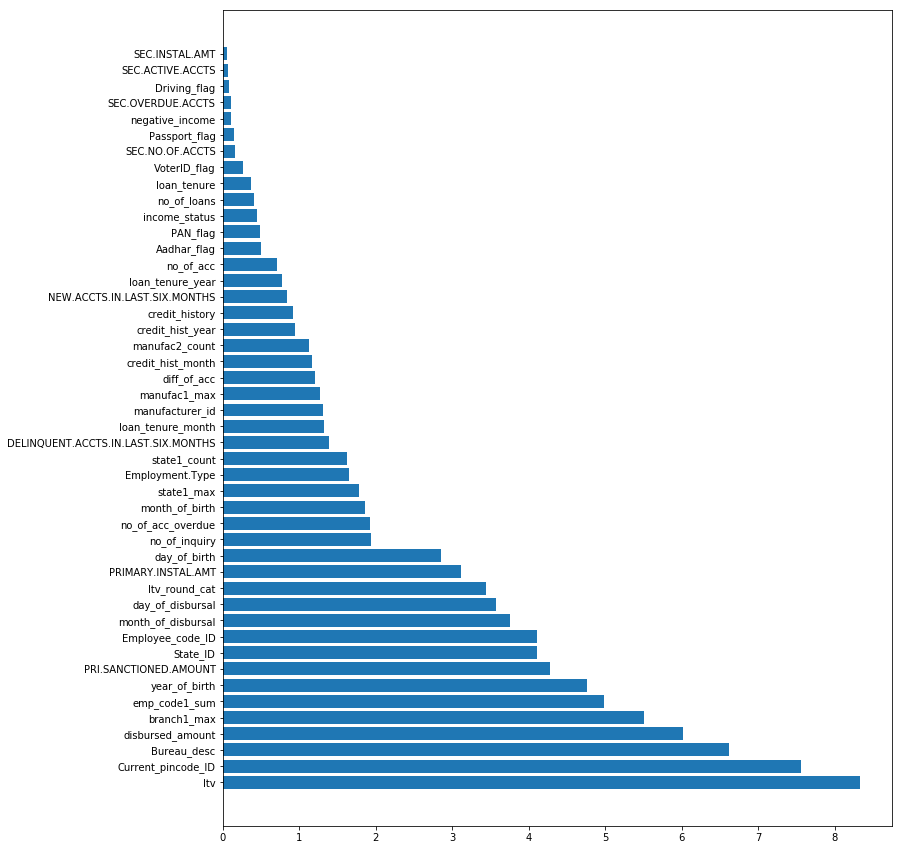

0.6713054267254843

In [46]:
run_cat_small('cat_feat_w_ltv', train_df, target, test_df, sub, 5)


0:	test: 0.6035075	best: 0.6035075 (0)	total: 57.2ms	remaining: 9m 32s
100:	test: 0.6573183	best: 0.6573304 (99)	total: 6.26s	remaining: 10m 13s
200:	test: 0.6647720	best: 0.6647720 (200)	total: 12.2s	remaining: 9m 55s
300:	test: 0.6676632	best: 0.6676632 (300)	total: 18.7s	remaining: 10m 1s
400:	test: 0.6690101	best: 0.6690101 (400)	total: 26.6s	remaining: 10m 37s
500:	test: 0.6696505	best: 0.6696721 (494)	total: 33.5s	remaining: 10m 35s
600:	test: 0.6701280	best: 0.6701703 (599)	total: 39.7s	remaining: 10m 20s
700:	test: 0.6705661	best: 0.6705705 (692)	total: 46.3s	remaining: 10m 14s
800:	test: 0.6708708	best: 0.6709018 (795)	total: 52.5s	remaining: 10m 2s
900:	test: 0.6713203	best: 0.6713815 (891)	total: 58.6s	remaining: 9m 51s
1000:	test: 0.6716375	best: 0.6716513 (998)	total: 1m 4s	remaining: 9m 44s
1100:	test: 0.6717965	best: 0.6718837 (1075)	total: 1m 10s	remaining: 9m 33s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6718837426
bestIteration = 1075

Shrink

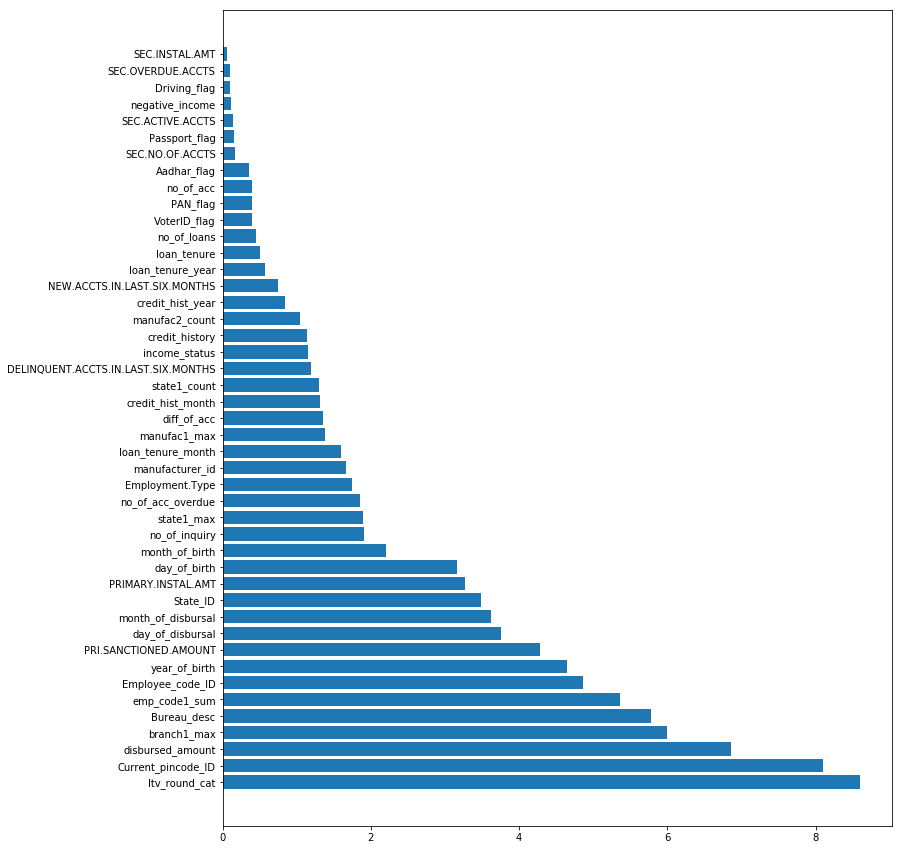

0.6718837426039952

In [47]:
run_cat_small('cat_feat_wo_ltv', train_df.drop('ltv', axis=1), target, 
              test_df.drop('ltv', axis=1), sub, 5)
